# 模块导入

In [22]:
import sys
import numpy as np
import pandas as pd
import os 
import gc
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import datetime
import time
import lightgbm as lgb
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from mlxtend.regressor import StackingRegressor
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# 数据处理

In [2]:
path  = '../ccf_car/'
train_sales  = pd.read_csv(path+'train_sales_data.csv')
train_search = pd.read_csv(path+'train_search_data.csv')
train_user   = pd.read_csv(path+'train_user_reply_data.csv')
evaluation_public = pd.read_csv(path+'evaluation_public.csv')
submit_example    = pd.read_csv(path+'submit_example.csv')
data = pd.concat([train_sales, evaluation_public], ignore_index=True)
data = data.merge(train_search, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = data.merge(train_user, 'left', on=['model', 'regYear', 'regMonth'])
data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)
data['bodyType'] = data['model'].map(train_sales.drop_duplicates('model').set_index('model')['bodyType'])
#LabelEncoder
for i in ['bodyType', 'model']:
    data[i] = data[i].map(dict(zip(data[i].unique(), range(data[i].nunique()))))
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth']

# 提取特征

In [3]:
unstack_data = {}
def getHistoryIncrease(dataset, stat_feat, step=1, wind=1, col='label'):
    """
    计算历史涨幅
    :param: step:月份跨度
    :param: wind:计算涨幅的月份区间
    :param: col:计算涨幅的目标列
    例：step=1,wind=2,计算当月 前第1月 较 前第3月 的涨幅）
    """
    if col not in unstack_data.keys():
        res = []
        bar = tqdm(dataset['province'].unique(), desc='history increase')
        for i in bar:
            for j in dataset['model'].unique():
                msk = (dataset['province']==i) & (dataset['model']==j)
                df = dataset[msk].copy().reset_index(drop=True)
                df = df[['mt',col]].set_index('mt').T
                df['province'] = i
                df['model'] = j
                res.append(df)
        res = pd.concat(res).reset_index(drop=True)
        unstack_data[col] = res.copy()
            
    res = unstack_data[col].copy()
    res_ = res.copy()
    for i in range(step+wind+1,29):
        res_[i] = (res[i-step] - res[i-(step+wind)]) / res[i-(step+wind)]
    for i in range(1,step+wind+1):
        res_[i]=np.NaN
    res = res_.set_index(['province','model']).stack().reset_index()
    res.rename(columns={0:'{}_last{}_{}_increase'.format(col,step,wind)},inplace=True)
    stat_feat.append('{}_last{}_{}_increase'.format(col,step,wind))
    dataset = pd.merge(dataset, res, on=['province','model','mt'], how='left')

    return dataset,stat_feat

In [17]:
def cal_windows_fea(df:pd.DataFrame, cal_col:str, stat_dim:list, data_type:str) -> pd.DataFrame:
    """
    计算滑窗特征
    """
    train_sales_data = get_data(df, data_type)

    name_prefix = "_".join(stat_dim) + "_%s"%cal_col

    # 滑窗特征
    ## 均值
    feature_data = train_sales_data.groupby(stat_dim)[cal_col].apply(lambda x: x.sum()).groupby(stat_dim[:-1]).rolling(3).mean()

    feature_data = feature_data.dropna().unstack(level=-1)

    if len(stat_dim) == 3:
        feature_data.index = feature_data.index.droplevel(0)
        feature_data.index = feature_data.index.droplevel(0)
    elif len(stat_dim) == 2:
        feature_data.index = feature_data.index.droplevel(0)


    feature_data.reset_index(inplace=True)
    feature_data = feature_data.rename(columns={k:"%s_rolling_mean_%d"%(name_prefix, k) for k in range(13)})

    ## std
    tmp_df = train_sales_data.groupby(stat_dim)[cal_col].apply(lambda x: x.sum()).groupby(stat_dim[:-1]).rolling(3).std()

    tmp_df = tmp_df.dropna().unstack(level=-1)

    if len(stat_dim) == 3:
        tmp_df.index = tmp_df.index.droplevel(0)
        tmp_df.index = tmp_df.index.droplevel(0)
    elif len(stat_dim) == 2:
        tmp_df.index = tmp_df.index.droplevel(0)


    tmp_df.reset_index(inplace=True)
    tmp_df = tmp_df.rename(columns={k:"%s_rolling_std_%d"%(name_prefix, k) for k in range(13)})

    feature_data = pd.merge(feature_data, tmp_df, on=stat_dim[:-1], how="left")

    ## sum
    tmp_df = train_sales_data.groupby(stat_dim)[cal_col].apply(lambda x: x.sum()).groupby(stat_dim[:-1]).rolling(3).sum()

    tmp_df = tmp_df.dropna().unstack(level=-1)

    if len(stat_dim) == 3:
        tmp_df.index = tmp_df.index.droplevel(0)
        tmp_df.index = tmp_df.index.droplevel(0)
    elif len(stat_dim) == 2:
        tmp_df.index = tmp_df.index.droplevel(0)

    tmp_df.reset_index(inplace=True)
    tmp_df = tmp_df.rename(columns={k:"%s_rolling_sum_%d"%(name_prefix, k) for k in range(13)})

    feature_data = pd.merge(feature_data, tmp_df, on=stat_dim[:-1], how="left")
    return feature_data

In [11]:
def get_stat_feature(df_,month):   
    df = df_.copy()
    stat_feat = []
    df['model_adcode'] = df['adcode'] + df['model']
    df['model_adcode_mt'] = df['model_adcode'] * 100 + df['mt']
    for col in tqdm(['label','popularity']):
        # shift
        for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
            stat_feat.append('shift_model_adcode_mt_{}_{}'.format(col,i))
            df['model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'] + i
            df_last = df[~df[col].isnull()].set_index('model_adcode_mt_{}_{}'.format(col,i))
            df['shift_model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'].map(df_last[col])    
    day_map = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    df['dayCount']=df['regMonth'].map(day_map)
    df.loc[(df.regMonth==2)&(df.regYear==2016),'dayCount']=29
    stat_feat.append('dayCount')
    df['salesVolume']/=df['dayCount']
    df['popularity']/=df['dayCount']
    # day_map = {1:-1,2:0,3:1,4:2,5:3,6:4,7:5,8:6,9:-5,10:-4,11:-3,12:-2}
    # day_map = {1:-1,2:0,3:1,4:2,5:100,6:100,7:100,8:100,9:100,10:100,11:100,12:-2}
    # df['spring']=df['regMonth'].map(day_map)
    unstack_data = {}
    base_step = month-1 if month-1>0 else 1
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step+1)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step+2)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step, wind=2)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step+1, wind=2)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step+2, wind=2)
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=base_step, wind=12)
    
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month, col='popularity')
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month+1, col='popularity')
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month+2, col='popularity')
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month, wind=2, col='popularity')
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month+1, wind=2, col='popularity')
    df,stat_feat = getHistoryIncrease(df,stat_feat, step=month+2, wind=2, col='popularity')
    
    df['salesVolume']*=df['dayCount']
    df['popularity']*=df['dayCount']
    
    return df,stat_feat

# 评价指标

In [12]:
def score(data, pred='pred_label', label='label', group='model'):
    data['pred_label'] = data['pred_label'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    data_agg = data.groupby('model').agg({
        pred:  list,
        label: [list, 'mean']
    }).reset_index()
    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns]
    nrmse_score = []
    for raw in data_agg[['{0}_list'.format(pred), '{0}_list'.format(label), '{0}_mean'.format(label)]].values:
        nrmse_score.append(
            mse(raw[0], raw[1]) ** 0.5 / raw[2]
        )
    print(1 - np.mean(nrmse_score))
    return 1 - np.mean(nrmse_score)	

# 模型选择

In [13]:
def get_model_type(train_x,train_y,valid_x,valid_y,m_type='lgb'):   
    if m_type == 'lgb':
        model = lgb.LGBMRegressor(
                                num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='mse',
                                max_depth=-1, learning_rate=0.05, min_child_samples=5, random_state=2019,
                                n_estimators=2000, subsample=0.9, colsample_bytree=0.7,
                                )
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              categorical_feature=cate_feat, 
              early_stopping_rounds=100, verbose=100)      
    elif m_type == 'xgb':
        model = xgb.XGBRegressor(
                                max_depth=5 , learning_rate=0.05, n_estimators=2000, 
                                objective='reg:gamma', tree_method = 'hist',subsample=0.9, 
                                colsample_bytree=0.7, min_child_samples=5,eval_metric = 'rmse' 
                                )
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              early_stopping_rounds=100, verbose=100)   
    return model

# 模型训练

In [14]:
def get_train_model(df_, m, m_type='lgb'):
    df = df_.copy()
    if m_type == 'lgb':
        for i in cate_feat:
            df[i] = df[i].astype('category')
    elif m_type == 'xgb':
        lbl = LabelEncoder()  
        for i in tqdm(cate_feat):
            df[i] = lbl.fit_transform(df[i].astype(str))
    # 数据集划分
    st = 13
    all_idx   = (df['mt'].between(st , m-1))
    train_idx = (df['mt'].between(st , m-5))
    valid_idx = (df['mt'].between(m-4, m-4))
    test_idx  = (df['mt'].between(m  , m  ))
    print('all_idx  :',st ,m-1)
    print('train_idx:',st ,m-5)
    print('valid_idx:',m-4,m-4)
    print('test_idx :',m  ,m  )  
    # 最终确认
    train_x = df[train_idx][features]
    train_y = df[train_idx]['label']
    valid_x = df[valid_idx][features]
    valid_y = df[valid_idx]['label']   
    # get model
    model = get_model_type(train_x,train_y,valid_x,valid_y,m_type)  
    # offline
    df['pred_label'] = model.predict(df[features])
    best_score = score(df[valid_idx]) 
    # online
    if m_type == 'lgb':
        model.n_estimators = model.best_iteration_ + 100
        model.fit(df[all_idx][features], df[all_idx]['label'], categorical_feature=cate_feat)
    elif m_type == 'xgb':
        model.n_estimators = model.best_iteration + 100
        model.fit(df[all_idx][features], df[all_idx]['label'])
    df['forecastVolum'] = model.predict(df[features]) 
    print('valid mean:',df[valid_idx]['pred_label'].mean())
    print('true  mean:',df[valid_idx]['label'].mean())
    print('test  mean:',df[test_idx]['forecastVolum'].mean())
    # 阶段结果
    sub = df[test_idx][['id']]
    sub['forecastVolum'] = df[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)  
    return model,sub,df[valid_idx]['pred_label']

# 逐步预测

In [26]:
for month in [25,26,27,28]: 
    m_type = 'xgb'#'lgb' 
    data_df, stat_feat = get_stat_feature(data,month-24)
    num_feat = ['regYear'] + stat_feat
    cate_feat = ['adcode','bodyType','model','regMonth']   
    features = num_feat + cate_feat
    print(len(features), len(set(features)))   
    xgb_model,sub,val_pred = get_train_model(data_df, month, m_type)   
    
    m_type = 'lgb' 
    data_df, stat_feat = get_stat_feature(data,month-24)
    num_feat = ['regYear'] + stat_feat
    cate_feat = ['adcode','bodyType','model','regMonth']  
    features = num_feat + cate_feat
    print(len(features), len(set(features)))   
    lgb_model,sub,val_pred = get_train_model(data_df, month, m_type)   
    
    all_idx = (data_df['mt'].between(13  , month-1  ))
    test_idx  = (data_df['mt'].between(month  , month  ))
    stacked_averaged_models = StackingRegressor(
        regressors=[xgb_model],
        meta_regressor= lgb_model
    )
    stacked_averaged_models.fit(data_df[all_idx][features], data_df[all_idx]['label'])
    sub['forecastVolum'] = stacked_averaged_models.predict(data_df[test_idx][features])
    sub['forecastVolum'] = sub['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)  
    
    
    data.loc[(data.regMonth==(month-24))&(data.regYear==2018), 'salesVolume'] = sub['forecastVolum'].values
    data.loc[(data.regMonth==(month-24))&(data.regYear==2018), 'label'      ] = sub['forecastVolum'].values	
sub = data.loc[(data.regMonth>=1)&(data.regYear==2018), ['id','salesVolume']]
sub.columns = ['id','forecastVolum']
sub[['id','forecastVolum']].round().astype(int).to_csv('../rst/yulao_063_CCF_sales_stacking.csv', index=False)


43 43



all_idx  : 13 24
train_idx: 13 20
valid_idx: 21 21
test_idx : 25 25
[0]	validation_0-rmse:841.375	validation_1-rmse:1046.8
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:800.241	validation_1-rmse:1004.61
[200]	validation_0-rmse:251.943	validation_1-rmse:361.342
[300]	validation_0-rmse:118.957	validation_1-rmse:208.219
[400]	validation_0-rmse:104.794	validation_1-rmse:197.68
[500]	validation_0-rmse:94.619	validation_1-rmse:194.414
[600]	validation_0-rmse:87.2869	validation_1-rmse:193.74
[700]	validation_0-rmse:80.4067	validation_1-rmse:191.649
[800]	validation_0-rmse:74.1717	validation_1-rmse:190.212
[900]	validation_0-rmse:69.349	validation_1-rmse:191.133
Stopping. Best iteration:
[838]	validation_0-rmse:72.4253	validation_1-rmse:189.641

0.777283776562614
valid mean: 614.6515502929688
true  mean: 649.3121212121212
test  mean: 612.8656005859375



43 43
all_idx  : 13 24
train_idx: 13 20
valid_idx: 21 21
test_idx : 25 25
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 7574.8	valid_1's l2: 35121.1
[200]	training's l2: 3928.48	valid_1's l2: 33248.5
[300]	training's l2: 2593.56	valid_1's l2: 32944.3
[400]	training's l2: 1740.25	valid_1's l2: 32789.1
[500]	training's l2: 1281.13	valid_1's l2: 32642.8
[600]	training's l2: 974.068	valid_1's l2: 32540.9
[700]	training's l2: 767.321	valid_1's l2: 32528.2
[800]	training's l2: 617.885	valid_1's l2: 32533.8
Early stopping, best iteration is:
[721]	training's l2: 732.662	valid_1's l2: 32501.4
0.7621523593987417
valid mean: 602.8650620742856
true  mean: 649.3121212121212
test  mean: 568.0401825059618



43 43



all_idx  : 13 25
train_idx: 13 21
valid_idx: 22 22
test_idx : 26 26
[0]	validation_0-rmse:866.608	validation_1-rmse:1007.37
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:825.41	validation_1-rmse:965.908
[200]	validation_0-rmse:261.235	validation_1-rmse:360.28
[300]	validation_0-rmse:122.565	validation_1-rmse:227.153
[400]	validation_0-rmse:108.335	validation_1-rmse:222.943
[500]	validation_0-rmse:97.8213	validation_1-rmse:221.588
[600]	validation_0-rmse:90.5369	validation_1-rmse:220.587
Stopping. Best iteration:
[586]	validation_0-rmse:91.4407	validation_1-rmse:220.113

0.7124610756349663
valid mean: 550.1776733398438
true  mean: 616.5537878787878
test  mean: 297.9572448730469



43 43
all_idx  : 13 25
train_idx: 13 21
valid_idx: 22 22
test_idx : 26 26
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 8054.06	valid_1's l2: 40205.4
[200]	training's l2: 4375.87	valid_1's l2: 40368.4
Early stopping, best iteration is:
[112]	training's l2: 7217.75	valid_1's l2: 40083.9
0.7407368625562902
valid mean: 628.0485155718363
true  mean: 616.5537878787878
test  mean: 326.2493005044287



43 43



all_idx  : 13 26
train_idx: 13 22
valid_idx: 23 23
test_idx : 27 27
[0]	validation_0-rmse:881.696	validation_1-rmse:1071.89
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:840.497	validation_1-rmse:1028.98
[200]	validation_0-rmse:268.642	validation_1-rmse:360.413
[300]	validation_0-rmse:130.319	validation_1-rmse:205.299
[400]	validation_0-rmse:115.521	validation_1-rmse:202.808
Stopping. Best iteration:
[373]	validation_0-rmse:118.46	validation_1-rmse:201.734

0.7565547032201083
valid mean: 599.0983276367188
true  mean: 673.0143939393939
test  mean: 445.1704406738281



43 43
all_idx  : 13 26
train_idx: 13 22
valid_idx: 23 23
test_idx : 27 27
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 9308.64	valid_1's l2: 34143.8
[200]	training's l2: 5046.37	valid_1's l2: 33822.1
Early stopping, best iteration is:
[140]	training's l2: 6948.05	valid_1's l2: 33660.6
0.7784281512206069
valid mean: 639.957177160244
true  mean: 673.0143939393939
test  mean: 503.1600556652157



43 43



all_idx  : 13 27
train_idx: 13 23
valid_idx: 24 24
test_idx : 28 28
[0]	validation_0-rmse:900.647	validation_1-rmse:1451.3
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:859.315	validation_1-rmse:1408.46
[200]	validation_0-rmse:274.929	validation_1-rmse:718.674
[300]	validation_0-rmse:135.946	validation_1-rmse:568.219
[400]	validation_0-rmse:120.391	validation_1-rmse:555.047
[500]	validation_0-rmse:111.589	validation_1-rmse:551.168
[600]	validation_0-rmse:102.914	validation_1-rmse:548.964
[700]	validation_0-rmse:95.7736	validation_1-rmse:547.637
[800]	validation_0-rmse:90.2692	validation_1-rmse:548.171
Stopping. Best iteration:
[739]	validation_0-rmse:93.041	validation_1-rmse:546.971

0.6068120887560093
valid mean: 654.4166259765625
true  mean: 899.8204545454546
test  mean: 421.88836669921875



43 43
all_idx  : 13 27
train_idx: 13 23
valid_idx: 24 24
test_idx : 28 28
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 10018.3	valid_1's l2: 300224
[200]	training's l2: 5551.7	valid_1's l2: 290839
[300]	training's l2: 3831.22	valid_1's l2: 290615
Early stopping, best iteration is:
[295]	training's l2: 3893.96	valid_1's l2: 290449
0.6111608290916246
valid mean: 650.645984444712
true  mean: 899.8204545454546
test  mean: 479.48189208712665


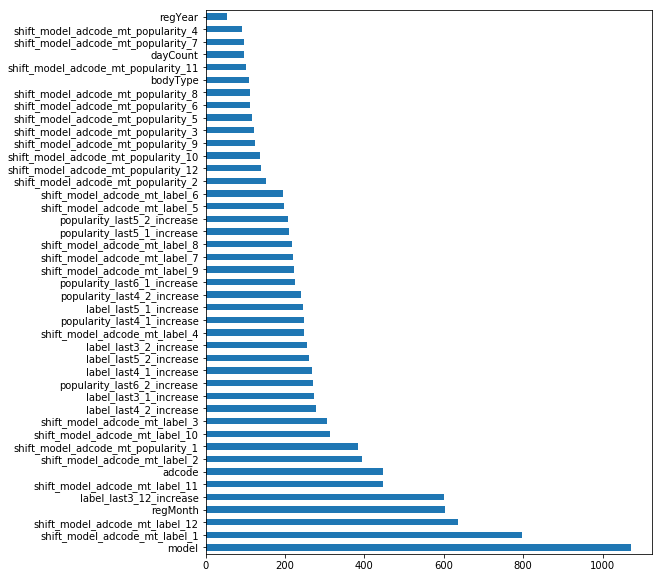

In [16]:
feat_imp = pd.Series(model.feature_importances_, index=data_df[features].columns)
feat_imp.nlargest(100).plot(kind='barh', figsize=(8,10))
plt.show()

In [29]:
data_df[features].sample(5)

,regYear,shift_model_adcode_mt_label_1,shift_model_adcode_mt_label_2,shift_model_adcode_mt_label_3,shift_model_adcode_mt_label_4,shift_model_adcode_mt_label_5,shift_model_adcode_mt_label_6,shift_model_adcode_mt_label_7,shift_model_adcode_mt_label_8,shift_model_adcode_mt_label_9,...,popularity_last29_1_increase,popularity_last30_1_increase,popularity_last28_2_increase,popularity_last29_2_increase,popularity_last30_2_increase,dayCount,adcode,bodyType,model,regMonth
27561,2017,338.0,233.0,238.0,304.0,215.0,250.0,182.0,462.0,1041.0,...,NaN,NaN,NaN,NaN,NaN,30,350000,1,52,9
35393,2018,160.0,297.0,586.0,357.0,353.0,287.0,193.0,160.0,223.0,...,NaN,NaN,NaN,NaN,NaN,31,350000,0,48,3
13540,2016,781.0,840.0,745.0,701.0,786.0,875.0,753.0,942.0,541.0,...,NaN,NaN,NaN,NaN,NaN,30,320000,1,15,11
1891,2016,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29,230000,0,25,2
11380,2016,2200.0,1835.0,1935.0,2095.0,1838.0,1159.0,846.0,2478.0,NaN,...,NaN,NaN,NaN,NaN,NaN,30,370000,1,37,9


In [31]:
data.head()

,adcode,bodyType,forecastVolum,id,model,province,regMonth,regYear,salesVolume,popularity,carCommentVolum,newsReplyVolum,label,mt
0,310000,0,NaN,0,0,上海,1,2016,292.0,1479.0,11.0,106.0,292.0,1
1,530000,0,NaN,0,0,云南,1,2016,466.0,1594.0,11.0,106.0,466.0,1
2,150000,0,NaN,0,0,内蒙古,1,2016,257.0,1479.0,11.0,106.0,257.0,1
3,110000,0,NaN,0,0,北京,1,2016,408.0,2370.0,11.0,106.0,408.0,1
4,510000,0,NaN,0,0,四川,1,2016,610.0,3562.0,11.0,106.0,610.0,1
